# Scikit-Learn Pipelines: A Tutorial

Scikit-learn pipelines are a great way of unifying and automating the processes such as data preprocessing, model fitting, cross validation, hyperparameter tuning, etc., used in a typical machine learning project. They are also really useful to avoid common pitfalls such as data leakage and other problems, as described on [this](https://scikit-learn.org/stable/common_pitfalls.html) page.

Furthermore, the wide variety of [preprocessing tools](https://scikit-learn.org/stable/api/sklearn.preprocessing.html) offered by scikit-learn offers endless possibilities in customizing preprocessing steps and feature engineering.

In this notebook I will explore some of the possibilities of scikit-learn pipelines.

A supervised machine learning project consists of (1) collecting the data, (2) splitting it into training and testing sets (3) preprocessing the training data, such as centering and scaling certain columns, ordinal-encoding certain columns, one-hot-encoding certain columns, introducing new features such as polynomial features, etc. (3) training different machine-learning models, (4) testing them on the testing set (5) model selection with hyper-paramter tuning, feature engineering, etc. using cross-validation, and so on.

In all the above steps, there is a lot of scope for error. For example, mistakes in data-preprocessing steps can occur. The same preprocessing that was done on the training data must be done on the test data, but the parameters for the preprocessing must come from the training data alone; otherwise we run into the problem of data-leakage. (As mentioned on the [scikit-learn](https://scikit-learn.org/stable/common_pitfalls.html) page: <font color=red>***The general rule is to never call `fit` on the test data.***</font>) This is where pipelines come in very useful, as they streamline and automate the repetitive steps of preprocessing, model fitting and testing, especially during cross validation or model selection.

However, it takes some time to get used to pipelines. So I thought a tutorial on this subject could be of some use to some people. 

A pipeline consists of a series of preprocessing steps and terminates with a model fitting step. A dataset can contain several features, some numerical, some categorical, and the preprocessing steps used for standardizing the data or feature engineering can be hugely diverse, implying that pipelines can be as complicated as possible. Some things to keep in mind are that a preprocessing step can either leave the number of columns unchanged, or increase the number of columns. Examples of the former are standard scaler, robust scaler, minmax scaler, ordinal-encoder, etc. Examples of the latter are one-hot-encoder, introducing polynomial features, etc. Also, we may want to leave some columns unchanged, drop some columns, and / or apply different preprocessors to different columns before fitting the model. Depending on the steps involved, the pipeline making process can involve different levels of complexity.

To navigate through all this, I thought of approaching this tutorial by successively addressing these increasing levels of complexity to cover these different cases. I was especially concerned with interpretability of machine learning models. While artificial neural networks and ensemble models like random forests can offer great performance in terms of metrics, it is difficult to interpret them. This lack of interpretability can be problematic in certain areas, where interpretability plays a key role. This is where feature engineering and model selection plays an important role.


The different levels of complexity I will consider are:

1. A single feature, with each preprocessing step simply transforming a column into a new column (i.e. introducing no new columns, such as ordinal encoder or standard scaling).
2. Multiple features, with each preprocessing step simply transforming a column into a new column (i.e. introducing no new columns, such as ordinal encoder or standard scaling).
3. Exactly as in 3., with the difference that some of the preprocessors can change the number of columns (examples are one-hot-encoding and polynomial features).
4. I will also consider how we can  overcome certain limitations with the available transformers by building custom transformers and/or pipelines.

(For our purposes a preprocessor can be either an imputer or an object from sklearn.preprocessing.)

As an application, a regression problem will be considered with numerical and categorical features. Pipelines together with cross validation techniques will be used to make proper feature selection and model selection (also hyperparameter optimization).


A small note here: one can use either `Pipeline` or `make_pipeline`. The only difference is that make_pipeline generates names for steps automatically. (https://stackoverflow.com/questions/40708077/what-is-the-difference-between-pipeline-and-make-pipeline-in-scikit-learn)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [2]:
#pd.set_option("display.precision", 3)

# **<font color=darkbrown>1. Single Features; Preprocessing Introduces No New Columns</font>**

First we'll create a dataset following a linear model with a single numerical feature. We will create training and test sets. Then we will preprocess the the features of the training data and fit a linear model on it.

* Data with single variable `x` and target variable `y`. 
* Feature preprocessed: `x`
* Preprocessor used: Standard scaler.


In [3]:
# create some regression data
random_state = 42
bias = 20.0
# define features and target
X, y, coef = make_regression(random_state=random_state, n_features=1, noise=2, coef=True, bias=bias)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=random_state)

In [4]:
print("Data follows linear model:\ny = b0 + b1*x\n")
print("With the coefficients:\n")
print(f"b1 = {coef},\nb0 = {bias}")

Data follows linear model:
y = b0 + b1*x

With the coefficients:

b1 = 41.7411003148779,
b0 = 20.0


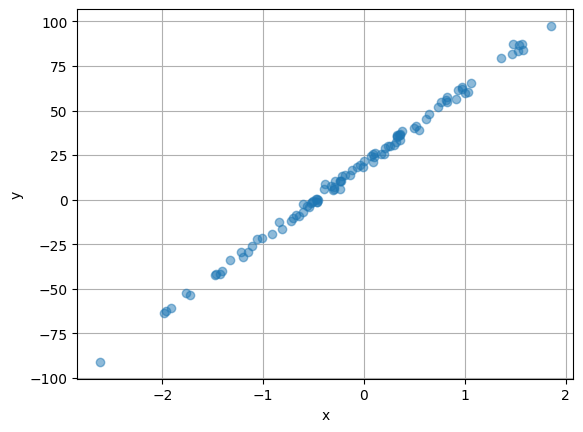

In [5]:
# plot the generated data
plt.plot(np.squeeze(X), y, linestyle="None", marker="o", alpha=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.grid();

## <font color=darkbrown>1.1. Creating the pipeline</font>

Now we'll create a  pipeline for preprocessing the training data and fitting the model on it. Then we'll use the same pipeline to predict on the test data. The various steps in the pipeline: preprocessing the features in the test set and applying the trained model, will be applied on the test data, hence **<font color=brown>there is no need to carry out the preprocessing steps on the testing data now.</font>**

A few words on scikit-learn pipelines before we go ahead and create one. A `Pipeline` is an object in which the parameter `steps` is specified as a list of steps to be carried out. Each step in this list is defined as a tuple. The tuple contains (1) a user-defined name (character string), and (2) a scikit-learn preprocessing object, such as `StandardScaler()` etc., or a scikit-learn imputer object, or a ColumnTransformer (see below) or even another pipeline. The last step in the list can (but need not, in which case you will only preprocess the data but not fit any model on it) be a scikit-learn estimator. Just like a scikit-learn model, the `Pipeline`-object is fitted on the training data using the `fit` method, and exactly like a scikit-learn model, can be used on the test data using the `predict` method.

(Alternatively one can use `make_pipeine` instead of Pipeline. The only difference is that you don't have to specify the names. (See [here](https://stackoverflow.com/questions/40708077/what-is-the-difference-between-pipeline-and-make-pipeline-in-scikit-learn).) For our purpose we'll continue to use `Pipeline`.)

In [6]:
# Pipeline steps:
#   step 1: standardize features using StandardScaler()
#   step 2: train a regression model on the training data
pipeline = Pipeline(steps=[('standardscaler', StandardScaler()),  
                        ('linearregression', LinearRegression())])
# fit the model on the training data:
pipeline.fit(X_train, y_train)
# predict on the test data:
ypred = pipeline.predict(X_test)
# obtain the metric (in this case mse):
mse = mean_squared_error(y_test, ypred)
print("\nMean-squared-error on the testing set: {}\n".format(round(mse,4)))


Mean-squared-error on the testing set: 3.6112



# <font color=darkbrown>2. Multiple Features; Preprocessing Introduces No New Columns</font>

When you have multiple columns, you are suddenly faced with a lot more options:

* You can drop certain columns.
* You can let certain columns pass through unchanged.
* You can apply a different preprocessor to certain columns and a different preprocessor to certain other columns. (For example, you may choose to apply `StandardScaler()` to continuous numerical variables and `OrdinalEncoder()` to ordinal categorical variables.)

Another question that becomes important is: What is the order of the columns (features) in the final preprocessed data before it is used for fitting a model?  This is relevant because we do not see the preprocessed data in a pipeline before it is used for fitting a model.

Hence in this section, the goal to understand is:

* How the preprocessing for multiple columns is done in a pipeline.
* What happens to the order of the columns that are passed through, preprocessed etc. 

I summarize the main points of this section below.

**Summary of this section:**
1. The columns in the final preprocessed feature matrix appear exactly in the order of the preprocessors specified in the `ColumnTransformer()`.
2. For each preprocessor, the variables defined for that preprocessor in the `ColumnTransformer` appear in the order in which the variables are defined for that preprocessor. 
3. Using `"passthrough"` as a preprocessor for certain columns is to be also treated as a preprocessor. In other words, if this preprocessor occurs first in the pipeline, the passthrough columns will also appear first (in the order specified in `passthorugh_columns`).
4. Using `remainder = passthrough` for the remaining columns, i.e., those not specified in the above preprocessors, will shift them to the final columns of the preprocessed feature matrix, exactly in the order in which they appeared in the original dataframe. (The preprocessed columns occuring earlier, as mentioned above.)

The above points will become clear after going through this section.

## <font color=darkbrown>2.1. Two Columns: Drop One and Preprocess the Other</font>

For preprocessing only certain columns, the `ColumnTransformer()` object from scikit-learn is very handy. Just like the `steps` parameter in the `Pipeline()` object, the `ColumnTransformer()` contains the parameter `transformers`, which is again a list of tuples. Each element of this list specifies a transformer. The transformer in turn is specified by a tuple containing a user-defined name of that transformer, the transformer object itself, and columns of the dataframe on which that transformer is to be applied.

*The transformer-object itself can be a scikit-learn preprocessing object such as StandardScaler() etc, or it can be another pipeline containing preprocessing steps (but not model-fitting steps).*


In [7]:
# create a dataframe with 2 columns:
df = pd.DataFrame(list(3*"ABC"),columns=["catvar"])
df["x"] = np.arange(9)
df

,catvar,x
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5
6,A,6
7,B,7
8,C,8


In [8]:
# standard scale the column x
# drop all other remaining columns

# Variables to standard scale:
vars_to_standardscale = ["x"]

# Define the ColumnTransformer:
#   Define list of transformers in 'transformers' parameter for each subset of variables to be preprocessed.
#   Drop the remaining variables with remainder="drop".
preprocessor_all_vars = ColumnTransformer(transformers = [("standardscaler",        # name given by the user
                                                           StandardScaler(),        # preprocessing-object
                                                           vars_to_standardscale)], # variables to preprocess
                                          remainder="drop")                         # drop the remaining variables

In [9]:
print("The preprocessed values of df[x] are:")
pd.DataFrame(preprocessor_all_vars.fit_transform(df), columns=["x_preprocessed"])

The preprocessed values of df[x] are:


,x_preprocessed
0,-1.549193
1,-1.161895
2,-0.774597
3,-0.387298
4,0.000000
5,0.387298
6,0.774597
7,1.161895
8,1.549193


You can also wrap the preprocessor object such as StandardScaler() into a pipeline. This makes it possible to combine multiple preprocessing steps into a single pipeline. (The pipeline in this case should include only preprocessing steps.)

In [10]:
# Wrap the preprocessor into a pipeline:
preproc_x = Pipeline([ ("standardscaler", StandardScaler()) ])

# Define the ColumnTransformer:
#   Define list of transformers in 'transformers' parameter for each subset of variables to be preprocessed.
#   Drop the remaining variables with remainder="drop".
preprocessor_all_vars = ColumnTransformer(transformers = [("preprocess_x",
                                                           preproc_x,
                                                           vars_to_standardscale)],
                                          remainder="drop")

In [11]:
print("The preprocessed values of df[x] are:")
pd.DataFrame(preprocessor_all_vars.fit_transform(df),columns=["x_preprocessed"])

The preprocessed values of df[x] are:


,x_preprocessed
0,-1.549193
1,-1.161895
2,-0.774597
3,-0.387298
4,0.000000
5,0.387298
6,0.774597
7,1.161895
8,1.549193


In the above, $x$ has been standardized with the StandardScaler(), and all the remaining variables (only catvar in this case) have been dropped using the `remainder` parameter.

## <font color=darkbrown>2.2. Two Columns: Leave One Unchanged and Preprocess the Other</font>

Using `remainder = "passthrough"` will let us retain the remaing columns unchanged, while preprocessing the others as required.

In [12]:
# Wrap the preprocessor into a pipeline:
preproc_x = Pipeline([ ("standardscaler", StandardScaler()) ])

# Define the ColumnTransformer:
#   Define list of transformers in 'transformers' parameter for each subset of variables to be preprocessed.
#   Let the remaining variables pass through with remainder="passthrough".
preprocessor_all_vars = ColumnTransformer(transformers = [("preprocess_x",
                                                           preproc_x,
                                                           vars_to_standardscale)],
                                          remainder="passthrough")

In [13]:
print("The preprocessed values of df[x] are:")
pd.DataFrame(preprocessor_all_vars.fit_transform(df),columns=["x_preprocessed", "catvar"])

The preprocessed values of df[x] are:


,x_preprocessed,catvar
0,-1.549193,A
1,-1.161895,B
2,-0.774597,C
3,-0.387298,A
4,0.0,B
5,0.387298,C
6,0.774597,A
7,1.161895,B
8,1.549193,C


We notice that all the remaining variables (only `catvar` in this case) are present unchanged in the preprocessed data. However, the order is different. While `catvar` was the first column in the original dataframe, it is now the second column in the preprocessed data. In other words, using `remainder = passthrough` makes the remaining variables which we have not explicitly preprocessed to appear *after* the variables that have been explicitly preprocessed.

## <font color=darkbrown>2.3. Two Columns: Explicitly Specifying Columns to Drop or Passthrough Unchanged</font>

We can also explicitly specify which variables we want to drop and which we want to pass through by passing `"drop"` or `"passthrough"` in the ColumnTransformer() instead of a scikit-learn preprocessor.

Let us show this by specifying `catvar` explicitly to be dropped.

In [14]:
# Variables to standard scale:
vars_to_standardscale = ["x"]

preproc_x = Pipeline([ ("standardscaler", StandardScaler()) ])

# Variables to drop:
vars_to_drop = ["catvar"]

dropper = "drop"

# Define the ColumnTransformer:
#   Define list of transformers in 'transformers' parameter for each subset of variables to be preprocessed.
#   Drop the remaining variables with remainder="drop".
preprocessor_all_vars = ColumnTransformer(transformers = [("standardscaler",        # name given by the user
                                                           preproc_x,        # preprocessing-object
                                                           vars_to_standardscale),  # variables to preprocess
                                                         ("dropper",     # name given by the user
                                                         dropper,        # preprocessing-object
                                                         vars_to_drop)]  # variables to preprocess
                                          )                      

In [15]:
pd.DataFrame(preprocessor_all_vars.fit_transform(df), columns=["x_preprocessed"])

,x_preprocessed
0,-1.549193
1,-1.161895
2,-0.774597
3,-0.387298
4,0.000000
5,0.387298
6,0.774597
7,1.161895
8,1.549193


Similarly, we can specify `catvar` explicitly to be retained by using the `"passthrough"` preprocessor for this. This is shown below.

In [16]:
# Variables to standard scale:
vars_to_standardscale = ["x"]

preproc_x = Pipeline([ ("standardscaler", StandardScaler()) ])

# Variables to retain:
vars_to_retain = ["catvar"]

retainer = "passthrough"

# Define the ColumnTransformer:
#   Define list of transformers in 'transformers' parameter for each subset of variables to be preprocessed.
#   Drop the remaining variables with remainder="drop".
preprocessor_all_vars = ColumnTransformer(transformers = [("standardscaler",        # name given by the user
                                                           preproc_x,        # preprocessing-object
                                                           vars_to_standardscale),  # variables to preprocess
                                                         ("retainer",     # name given by the user
                                                         retainer,        # preprocessing-object
                                                         vars_to_retain)] # variables to preprocess
                                          )                      

In [17]:
pd.DataFrame(preprocessor_all_vars.fit_transform(df), columns=["x_preprocessed", "catvar"])

,x_preprocessed,catvar
0,-1.549193,A
1,-1.161895,B
2,-0.774597,C
3,-0.387298,A
4,0.0,B
5,0.387298,C
6,0.774597,A
7,1.161895,B
8,1.549193,C


Notice how catvar comes after x.

Now let us change the order of the transformers, so that the retainer comes first and then the standard scaler.

In [18]:
# Variables to standard scale:
vars_to_standardscale = ["x"]

preproc_x = Pipeline([ ("standardscaler", StandardScaler()) ])

# Variables to retain:
vars_to_retain = ["catvar"]

retainer = "passthrough"

# Define the ColumnTransformer:
#   Define list of transformers in 'transformers' parameter for each subset of variables to be preprocessed.
#   Drop the remaining variables with remainder="drop".
preprocessor_all_vars = ColumnTransformer(transformers = [("retainer",        # name given by the user
                                                           retainer,        # preprocessing-object
                                                           vars_to_retain),  # variables to preprocess
                                                         ("standardscaler",     # name given by the user
                                                         preproc_x,        # preprocessing-object
                                                         vars_to_standardscale)] # variables to preprocess
                                          )                      

In [19]:
pd.DataFrame(preprocessor_all_vars.fit_transform(df), columns=["catvar", "x_preprocessed"])

,catvar,x_preprocessed
0,A,-1.549193
1,B,-1.161895
2,C,-0.774597
3,A,-0.387298
4,B,0.0
5,C,0.387298
6,A,0.774597
7,B,1.161895
8,C,1.549193


Note how the `catvar` variables comes first in this case. **This is because the order of the transformers in the list given to the `transformers` parameter always takes precedence.**

## <font color=darkbrown>2.4. More Columns</font>

### <font color=darkbrown>2.4.1. Order of the columns</font>

We saw the general rule that the columns explicitly preprocessed  appear first (regardless of their order in the original dataframe, and even is the preprocessor is `"passthrough"`) and the remaining columns appear at the end if we have `remainder = "passthrough"`. In the above case there were only 2 columns, so we did passthrough for only one column and preprocessed the other. What if there are more than one columns to pass through? And how does it matter if the passthrough is specified for the remainding variables via the `remainder` parameter or explicitly specified via a preprocessor for the specific variables to be passed through? These are the questions we will consider in this section.

In [20]:
df = pd.DataFrame(list(3*"ABC"),columns=["cv2"])
df["cv1"] = list(3*"A")+list(3*"B")+list(3*"C")
df["x1"] = np.arange(9)
df["x2"] = df["x1"]**2
df["av2"] = list(3*"X")+list(3*"Y")+list(3*"Z")
df

,cv2,cv1,x1,x2,av2
0,A,A,0,0,X
1,B,A,1,1,X
2,C,A,2,4,X
3,A,B,3,9,Y
4,B,B,4,16,Y
5,C,B,5,25,Y
6,A,C,6,36,Z
7,B,C,7,49,Z
8,C,C,8,64,Z


In [21]:
drop_cols = ["x2"]
passthrough_cols = ["av2", "cv1"]
# define a preprocessor to drop
preprocessor_drop = "drop"
# define a preprocessor to pass through
preprocessor_passthrough = "passthrough"
preprocessor_all_vars = ColumnTransformer(transformers = [("drop_cols", 
                                                           preprocessor_drop, 
                                                           drop_cols),
                                                          ("passthrough_cols", 
                                                           preprocessor_passthrough, 
                                                           passthrough_cols)],
                                          remainder="passthrough")

In [22]:
pd.DataFrame(preprocessor_all_vars.fit_transform(df), columns=["av2", "cv1", "cv2", "x1"])

,av2,cv1,cv2,x1
0,X,A,A,0
1,X,A,B,1
2,X,A,C,2
3,Y,B,A,3
4,Y,B,B,4
5,Y,B,C,5
6,Z,C,A,6
7,Z,C,B,7
8,Z,C,C,8


In the above we see that `x2` has been dropped (0, 1, 4, 9, etc.). The passthrough columns specified in `passthrough_cols` are `av2` and `cv1`; and these appear first, and exactly in the order speicified in `passthrough_cols`, even though in the orginal dataframe they come in a different order. Finally, the remaining columns appear last, in the same order as they were in the original dataframe, i.e. `cv2` and `x1`.

Thus:

* The order of the transformers is given first precedence.
* Within each transformer, the order of the variables defined for that transformer is followed: even if this is different from the order in the original dataframe.
* (Note that the transformers can include the `"passthrough"` object as well, i.e. the preprocessing is like the identity transformation.)
* The remaining variables, if `remainder="passthrough"` is specified, appear at the end, exactly in the order in which they were present in the original dataframe.

### <font color=darkbrown>2.4.2. Applying different preprocessors to different variables</font>

Let us apply a `MinMaxScaler()` to `x1` and `x2` and an ordinal encoder to `cv2`. (The values A B C in the column `cv2` will be mapped to 1, 2, 3 by the ordinal encoder.)

In [23]:
df = pd.DataFrame(list(3*"ABC"),columns=["cv2"])
df["cv1"] = list(3*"A")+list(3*"B")+list(3*"C")
df["x1"] = np.arange(9)
df["x2"] = df["x1"]**2
df["av2"] = list(3*"X")+list(3*"Y")+list(3*"Z")
df

,cv2,cv1,x1,x2,av2
0,A,A,0,0,X
1,B,A,1,1,X
2,C,A,2,4,X
3,A,B,3,9,Y
4,B,B,4,16,Y
5,C,B,5,25,Y
6,A,C,6,36,Z
7,B,C,7,49,Z
8,C,C,8,64,Z


In [24]:
vars_to_minmaxscale = ["x2", "x1"]
vars_to_ordinalencode = ["cv2"]

preprocessor_minmax = Pipeline([ ("minmaxscaler", MinMaxScaler()) ])
preprocessor_ord_enc = Pipeline([ ("ordinalencoder", OrdinalEncoder()) ])

preprocessor_all_vars = ColumnTransformer(transformers = [("preprocess_minmax",
                                                           preprocessor_minmax,
                                                           vars_to_minmaxscale),
                                                          ("preprocess_ord_enc",
                                                           preprocessor_ord_enc,
                                                           vars_to_ordinalencode)],
                                          remainder="passthrough")

In [25]:
pd.DataFrame(preprocessor_all_vars.fit_transform(df), columns=["x2_minmaxscaled", 
                                                               "x1_minmaxscaled", 
                                                               "cv2_ordinallyencoded",
                                                              "cv1", "av2"])

,x2_minmaxscaled,x1_minmaxscaled,cv2_ordinallyencoded,cv1,av2
0,0.0,0.0,0.0,A,X
1,0.015625,0.125,1.0,A,X
2,0.0625,0.25,2.0,A,X
3,0.140625,0.375,0.0,B,Y
4,0.25,0.5,1.0,B,Y
5,0.390625,0.625,2.0,B,Y
6,0.5625,0.75,0.0,C,Z
7,0.765625,0.875,1.0,C,Z
8,1.0,1.0,2.0,C,Z


Let us go through the above one by one.

* In `ColumnTransformer()`, the first transformer `preprocessor_minmax`. The variables and the order of the variables for this transformer are defined in `vars_to_minmaxscale` as `x2` and `x1`. Hence the transformed versions of these will appear first in the feature matrix. This is what we see in the first two columns above.
* The next transformer in `ColumnTransformer()` is `preprocessor_ord_enc`. The variables for this is defined in `vars_to_ordinalencode` and contains only `cv2`. Hence the ordinally encoded version of `cv2` appears next (the 3rd column above).
* The remaining columns are `cv1` and `av2`, and since we have specified `remainder = passthrough`, these will appear at the end in the same order that they appear in the original dataframe, i.e. `cv1` and `av2`. This is what we see in columns 4 and 5 above

## <font color=darkbrown>2.5. Accessing the Individual Preprocessors</font>

The various elements in a pipeline can be accessed in a tree like structure. This is useful as we can then inspect them for the values they have stored.

`ColumnTransformer()` has an attribute called `named_transformers_`.

`Pipeline()` has an attribute called `named_steps`.

The `named_transformers_` attribute of a `ColumnTransformer()` lists the transformers as defined by the user. For `preprocessor_all_vars` defined above we have:

In [26]:
preprocessor_all_vars.named_transformers_

{'preprocess_minmax': Pipeline(steps=[('minmaxscaler', MinMaxScaler())]),
 'preprocess_ord_enc': Pipeline(steps=[('ordinalencoder', OrdinalEncoder())]),
 'remainder': 'passthrough'}

The above shows that:

* the first transformer is called `preprocess_minmax` and is a Pipeline, which in turn consists of an instance of the `MinMaxScaler()` object called `"minmaxscaler"`.
* the second transformer is called `preprocess_minmax` and is a Pipeline, which in turn consists of an instance of the `OrdinalEncoder()`object called `"ordinalencoder"`.

Let us look at the second pipeline (which is called `preprocess_ord_enc`). Its structure can be accessed via the pipeline attribute `named_steps` as follows:

In [27]:
pipeline2 = preprocessor_all_vars.named_transformers_["preprocess_ord_enc"]
pipeline2.named_steps

{'ordinalencoder': OrdinalEncoder()}

The above shows that this pipeline consists an instance of the class `OrdinalEncoder()` called `"ordinalencoder"`. This instance can be simply by defining `pipeline2.named_steps["ordinalencoder"]`, which is an instance of the `OrdinalEncoder()` class, as can be seen from the `type` command:

In [28]:
type(pipeline2.named_steps["ordinalencoder"])

sklearn.preprocessing._encoders.OrdinalEncoder

This is how we can access the specific elements of a pipeline or columntransformer. For example, if we want to look at what attributes such as categores etc. are saved in the above object, we can simply do the following:

In [29]:
oe = pipeline2.named_steps["ordinalencoder"]
print("Columns encoded by the ordinal encoder:\n")
print(oe.feature_names_in_)
print("\nCategories encoded by the ordinal encoder:\n")
print(oe.categories_)

Columns encoded by the ordinal encoder:

['cv2']

Categories encoded by the ordinal encoder:

[array(['A', 'B', 'C'], dtype=object)]


Similarly we can access the attributes of the `MinMaxScaler()` object as follows:

In [30]:
minmaxe = preprocessor_all_vars.named_transformers_["preprocess_minmax"].named_steps["minmaxscaler"]
print("Columns encoded by the minmax encoder:\n")
print(minmaxe.feature_names_in_)

print("\nMinimum of columns x2 and x1:\n")
print(minmaxe.data_min_)
print("\nMaximum of columns x2 and x1:\n")
print(minmaxe.data_max_)



Columns encoded by the minmax encoder:

['x2' 'x1']

Minimum of columns x2 and x1:

[0. 0.]

Maximum of columns x2 and x1:

[64.  8.]


# <font color=darkbrown>3. Multiple Features: Preprocessing Introduces New Columns</font>



When considering preprocessing which introduce new columns, the basic principles about the ordering remains the same: the variables occur in the order in which the transformers are arranged, and within each transformer, the order for the variables specified for that transformer is followed.

Examples of preprocessing steps which introduce new columns are the `PolynomialFeatures()` and `OneHotEncoder()` objects from scikit-learn.



## <font color=darkbrown>3.1. First Example: One-Hot-Encoder</font>

In [31]:
df = pd.DataFrame(list(3*"ABC"),columns=["cv2"])
df["cv1"] = list(3*"A")+list(3*"B")+list(3*"C")
df["av2"] = list(3*"Y")+list(3*"X")+list(3*"Z")
df["x1"] = np.arange(9)
df["x2"] = df["x1"]**2
df

,cv2,cv1,av2,x1,x2
0,A,A,Y,0,0
1,B,A,Y,1,1
2,C,A,Y,2,4
3,A,B,X,3,9
4,B,B,X,4,16
5,C,B,X,5,25
6,A,C,Z,6,36
7,B,C,Z,7,49
8,C,C,Z,8,64


In [32]:
vars_to_ordinalencode = ["cv1"]
vars_to_ohe = ["av2"]

preprocessor_ord_enc = Pipeline([ ("ordinalencoder", OrdinalEncoder()) ])
preprocessor_ohe = Pipeline([ ("ordinalencoder", OneHotEncoder()) ])

preprocessor_all_vars = ColumnTransformer(transformers = [("preprocess_ord_enc",
                                                           preprocessor_ord_enc,
                                                           vars_to_ordinalencode),
                                                          ("preprocess_ohe",
                                                           preprocessor_ohe,
                                                           vars_to_ohe)],
                                          remainder="passthrough")

In [33]:
pd.DataFrame(preprocessor_all_vars.fit_transform(df),
             columns = ["cv1_OrdEnc",
                        "av2_OHE_X", 
                        "av2_OHE_Y", 
                        "av2_OHE_Z", 
                        "cv2_unchanged", 
                        "x1_unchanged", 
                        "x2_unchanged"])

,cv1_OrdEnc,av2_OHE_X,av2_OHE_Y,av2_OHE_Z,cv2_unchanged,x1_unchanged,x2_unchanged
0,0.0,0.0,1.0,0.0,A,0,0
1,0.0,0.0,1.0,0.0,B,1,1
2,0.0,0.0,1.0,0.0,C,2,4
3,1.0,1.0,0.0,0.0,A,3,9
4,1.0,1.0,0.0,0.0,B,4,16
5,1.0,1.0,0.0,0.0,C,5,25
6,2.0,0.0,0.0,1.0,A,6,36
7,2.0,0.0,0.0,1.0,B,7,49
8,2.0,0.0,0.0,1.0,C,8,64


* The first transformer is the ordinal encoder for cv1, and that is what we see in the first column. 
* The second transformer is the one-hot.encoder for av2, and this is what we see in the 2nd, 3rd and 4th columns.
* The remaining variables are passed through, which is what we see in the end (cv2, x1 and x2).

Another example is given below for you to understand the order of the columns in the preprocessed feature matrix:

In [34]:
vars_to_ordinalencode = ["cv1"]
vars_to_ohe = ["av2","cv2"]

preprocessor_ord_enc = Pipeline([ ("ordinalencoder", OrdinalEncoder()) ])
preprocessor_ohe = Pipeline([ ("ordinalencoder", OneHotEncoder()) ])

preprocessor_all_vars = ColumnTransformer(transformers = [("preprocess_ord_enc",
                                                           preprocessor_ord_enc,
                                                           vars_to_ordinalencode),
                                                          ("preprocess_ohe",
                                                           preprocessor_ohe,
                                                           vars_to_ohe)],
                                          remainder="passthrough")

In [35]:
pd.DataFrame(preprocessor_all_vars.fit_transform(df),
             columns = ["cv1_OrdEnc",
                        "av2_OHE_X", 
                        "av2_OHE_Y", 
                        "av2_OHE_Z",
                        "cv2_OHE_A", 
                        "cv2_OHE_B", 
                        "cv2_OHE_C",
                        "x1_unchanged", 
                        "x2_unchanged"])

,cv1_OrdEnc,av2_OHE_X,av2_OHE_Y,av2_OHE_Z,cv2_OHE_A,cv2_OHE_B,cv2_OHE_C,x1_unchanged,x2_unchanged
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,4.0
3,1.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,9.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,16.0
5,1.0,1.0,0.0,0.0,0.0,0.0,1.0,5.0,25.0
6,2.0,0.0,0.0,1.0,1.0,0.0,0.0,6.0,36.0
7,2.0,0.0,0.0,1.0,0.0,1.0,0.0,7.0,49.0
8,2.0,0.0,0.0,1.0,0.0,0.0,1.0,8.0,64.0


## <font color=darkbrown>3.2. Second Example: Polynomial Features</font>

Here I will use the `PolynomialFeatures()` preprocessor from scikit-learn to generate polynomial features of a specified degree of certain combination of variables.

By default, all combinations of the features will be considered. But we have the option of including mixed terms only by setting `interaction_only = True`. 

It is also important to understand the order in which the columns are created. Suppose we have four columns A, B, C and D, and we look at second degree polynomial features, then we will get the following order for the second degree columns (see [here](https://stackoverflow.com/questions/64820999/what-is-the-formula-behind-scikit-learn-polynomialfeatures)):

* For `interaction_only=True`: AB AC AD BC BD CD.
* For `interaction_only=False`: AA AB AC AD BB BC BD CC CD DD.

This is especially powerful when used in combination with one-hot-encoding in the context of mixed linear regression models, as we will see later.

For illustration purposes I show below how the PolynimialFeatures() preprocessor works for the second degree when we have three variables in a toy dataframe, first with `interaction_only = False` (the default value), then with `interaction_only = True`.


In [36]:
df = pd.DataFrame({"x":[1,2,3,5]})
df["y"] = [1,4,9,16]
df["plus_minus"] = [1,-1, 1, -1]
df

,x,y,plus_minus
0,1,1,1
1,2,4,-1
2,3,9,1
3,5,16,-1


In [37]:
poly = PolynomialFeatures(2, include_bias=False)
colnames = ["x", "y", "plus_minus", "x_x", "x_y", "x_plus_minus", "y_y", "y_plus_minus", "plus_minus_plus_minus"]
pd.DataFrame(poly.fit_transform(df), columns=colnames)

,x,y,plus_minus,x_x,x_y,x_plus_minus,y_y,y_plus_minus,plus_minus_plus_minus
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2.0,4.0,-1.0,4.0,8.0,-2.0,16.0,-4.0,1.0
2,3.0,9.0,1.0,9.0,27.0,3.0,81.0,9.0,1.0
3,5.0,16.0,-1.0,25.0,80.0,-5.0,256.0,-16.0,1.0


In [38]:
poly = PolynomialFeatures(2, include_bias=False, interaction_only=True)
colnames = ["x", "y", "plus_minus",  "x_y", "x_plus_minus", "y_plus_minus"]
pd.DataFrame(poly.fit_transform(df), columns=colnames)

,x,y,plus_minus,x_y,x_plus_minus,y_plus_minus
0,1.0,1.0,1.0,1.0,1.0,1.0
1,2.0,4.0,-1.0,8.0,-2.0,-4.0
2,3.0,9.0,1.0,27.0,3.0,9.0
3,5.0,16.0,-1.0,80.0,-5.0,-16.0


### <font color=darkbrown>3.2.1. Applying `PolynomialFeatures()` on a single variable</font>

For purposes of demonstration, I'll create a dataset with a single feature variable and a target variable that depends quadratically on the feature.



In [39]:
def create_quadratic_function():
    npts = 1000
    noise = 500.0
    seed = 5

    # parameters of the quadratic fit
    b0 = -2.0
    b1 = -40.0
    b2 = 0.1

    np.random.seed(seed)
    df = pd.DataFrame(np.arange(npts), columns=["x"])
    df["y"] = b0 + b1*df["x"] + b2*df["x"]**2 + noise*np.random.randn(npts)
    return df

In [40]:
df = create_quadratic_function()
df.head()

,x,y
0,0,218.613743
1,1,-207.335076
2,2,1133.785594
3,3,-247.146065
4,4,-105.595079


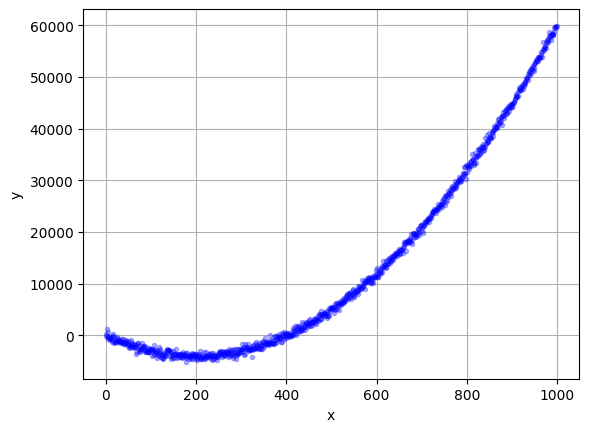

In [41]:
plt.plot(df["x"],df["y"],linestyle="None",marker=".",alpha=0.3,color="blue")
plt.xlabel("x")
plt.ylabel("y")
plt.grid();

**<font color=darkbrown>Fitting a model without a pipeline</font>**

Now I'll introduce a second degree polynomial feature (i.e. $x^2$) and standardize both columns $x$ and $x^2$. Thereafter I'll fit a linear regression model in $x$ and $x^2$. At this stage I'll do it without a pipeline.

In [42]:
poly = PolynomialFeatures(2, include_bias=False)

X = df[["x"]]
y = df["y"]
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7, random_state = 30)
train_index = X_train.index
test_index = X_test.index

polyfeatures = PolynomialFeatures(degree=2, include_bias=False) # degree is 2 by default
standard_scaler = StandardScaler()

X_train = polyfeatures.fit_transform(X_train)
X_train = standard_scaler.fit_transform(X_train)

# Normalized X_train
pd.DataFrame(X_train, columns=["x_normalized", "xsq_normalized"]).head()

,x_normalized,xsq_normalized
0,1.064734,1.057745
1,-0.214005,-0.470676
2,1.405267,1.618228
3,-1.246031,-1.040537
4,-0.286977,-0.530445


In [43]:
# fit a linear regression model 
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# transform the test set
X_test = polyfeatures.transform(X_test)
X_test = standard_scaler.transform(X_test)

# predict on the test set
ypred = linreg.predict(X_test)
print("\nMean squared error on test set = {}".format(mean_squared_error(y_test, ypred)))


Mean squared error on test set = 244188.93092435016


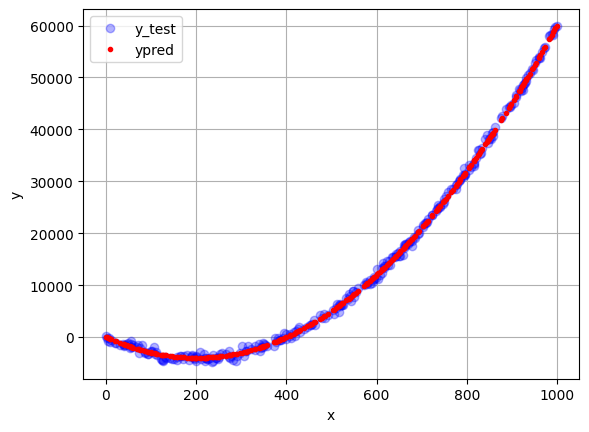

In [44]:
# plot the predictions on the test set
plt.plot(X.loc[test_index],y.loc[test_index],linestyle="None",marker="o",alpha=0.3,color="blue")
plt.plot(X.loc[test_index],ypred,linestyle="None",marker=".",alpha=1,color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["y_test", "ypred"])
plt.grid();

<font color=darkbrown>**Fitting a model with a pipeline but without ColumnTransformer()**</font>

Now we fit amodel with a pipeline. As this present case is simple enough, we do not need a ColumnTransformer and can go ahead directly with a Pipeline.

In [45]:
df = create_quadratic_function()

X = df[["x"]]
y = df["y"]
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7, random_state = 30)

preproc_sq = PolynomialFeatures(include_bias=False, degree=2)
standard_scaler = StandardScaler()
pipeline = Pipeline(steps = [("introduce_x_square", preproc_sq),
                             ("standard_scaler", standard_scaler),
                             ("regressor", LinearRegression())])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('introduce_x_square', PolynomialFeatures(include_bias=False)),
                ('standard_scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [46]:
ypred = pipeline.predict(X_test)
print("Mean squared error on test set = {}".format(mean_squared_error(y_test, ypred)))

Mean squared error on test set = 244188.93092435016


We get the same MSE as earlier. Notice how the process is considerably simplified with a pipeline than in the case without.

By the way, the preprocessed data before fitting the model can be accessed as follows.

In [47]:
df = create_quadratic_function()

X = df[["x"]]
y = df["y"]
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7, random_state = 30)

preproc_sq = PolynomialFeatures(include_bias=False, degree=2)
standard_scaler = StandardScaler()
pipeline_preprocessor = Pipeline(steps = [("introduce_x_square", preproc_sq),
                             ("standard_scaler", standard_scaler)])

pd.DataFrame(pipeline_preprocessor.fit_transform(X_train), columns=["x_normalized", "xsq_normalized"]).head()

,x_normalized,xsq_normalized
0,1.064734,1.057745
1,-0.214005,-0.470676
2,1.405267,1.618228
3,-1.246031,-1.040537
4,-0.286977,-0.530445


So the transformed Xtrain and Xtest are the same as the earlier (i.e. without pipeline) transformed Xtrain and Xtest.

Note also that the order is important. Above we have first used `preproc_sq` to produce $x$ and $x^2$. Then we have used `standard_scaler` produces $x_{norm}$ and $(x^2)_{norm}$.

If `standard_scaler` is used first and then `preproc_sq`, then we get $x_{norm}$ and $(x_{norm})^2$, as we can easily check:




In [48]:
df = create_quadratic_function()

# first standard scale, then square:
X = df[["x"]]
y = df["y"]
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7, random_state = 30)

preproc_sq = PolynomialFeatures(include_bias=False, degree=2)
standard_scaler = StandardScaler()
pipeline_preprocessor = Pipeline(steps = [("standard_scaler", standard_scaler),
                                          ("introduce_x_square", preproc_sq)])

pd.DataFrame(pipeline_preprocessor.fit_transform(X_train),columns=["x-normalized", "square of x-normalized"]).head()

,x-normalized,square of x-normalized
0,1.064734,1.133658
1,-0.214005,0.045798
2,1.405267,1.974776
3,-1.246031,1.552592
4,-0.286977,0.082356


As can be easily checked the second column is the square of the first column.

<font color=darkbrown>**Using a pipeline with ColumnTransformer**</font>

Using `ColumnTransfer()` gives more flexibiltiy for more complicated cases than the present one. But there are some complications in using a `ColumnTransfer()` in this case which I'll address in this section.

* First, there is a wrong way of using it, which is shown below.

In [49]:
df = create_quadratic_function()
X = df[["x"]]
y = df["y"]
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7, random_state = 30)
X_train.head()

,x
802,802
434,434
900,900
137,137
413,413


In [50]:
preproc_sq = PolynomialFeatures(include_bias=False, degree=2)
standard_scaler = StandardScaler()

# THIS IS WRONG!!!
preprocessor_all_vars = ColumnTransformer(transformers = [("poly", 
                                                           preproc_sq,
                                                          ["x"]),
                                                         ("standardscale_r", 
                                                           standard_scaler,
                                                          ["x"])],
                                          remainder="drop")

In [51]:
print(16*"-")
print("WRONG METHOD")
print(16*"-")
pd.DataFrame(preprocessor_all_vars.fit_transform(X_train), columns=["x", "x_square", "x_norm"] )

----------------
WRONG METHOD
----------------


,x,x_square,x_norm
0,802.0,643204.0,1.064734
1,434.0,188356.0,-0.214005
2,900.0,810000.0,1.405267
3,137.0,18769.0,-1.246031
4,413.0,170569.0,-0.286977
...,...,...,...
695,500.0,250000.0,0.015334
696,813.0,660969.0,1.102957
697,941.0,885481.0,1.547735
698,421.0,177241.0,-0.259178


* First we get poly features of x (2 columns in total): the first 2 columns.
* Then standard scaler standardizes the original x column: the 3rd column.
* This is not what we want. Passing x in both the columns is the problem. We must pass it only once.

Here is the right way to do it.

In [52]:
preproc_sq = PolynomialFeatures(include_bias=False, degree=2)
standard_scaler = StandardScaler()

# Correct way:
# Define a new pipeline which creates polynomial features and standardizes
preprocess_x = Pipeline([("poly", preproc_sq),
                         ("scaler", StandardScaler())])

# Wrap the pipeline into a ColumnTransformer 
# specify "x" as its variables.
preprocessor_all_vars = ColumnTransformer(transformers = [("poly_and_scale", 
                                                           preprocess_x,
                                                          ["x"])],
                                          remainder="drop")

In [53]:
print(16*"-")
print("CORRECT METHOD")
print(16*"-")
pd.DataFrame(preprocessor_all_vars.fit_transform(X_train), columns=["x_norm", "xsq_norm"])

----------------
CORRECT METHOD
----------------


,x_norm,xsq_norm
0,1.064734,1.057745
1,-0.214005,-0.470676
2,1.405267,1.618228
3,-1.246031,-1.040537
4,-0.286977,-0.530445
...,...,...
695,0.015334,-0.263534
696,1.102957,1.117441
697,1.547735,1.871866
698,-0.259178,-0.508025


Now the features have been correctly preprocessed.

**Let us now train the model with the pipeline**

In [54]:
df = create_quadratic_function()
X = df[["x"]]
y = df["y"]
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7, random_state = 30)

preproc_sq = PolynomialFeatures(include_bias=False, degree=2)
standard_scaler = StandardScaler()

preprocess_x = Pipeline([("poly", preproc_sq),
                         ("scaler", StandardScaler())])


preprocessor_all_vars = ColumnTransformer(transformers = [("poly_and_scale", 
                                                           preprocess_x,
                                                          ["x"])],
                                          remainder="drop")
final_pipeline = Pipeline([
    ("final_preprocessor",preprocessor_all_vars), 
    ("model",LinearRegression())
])

In [55]:
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('final_preprocessor',
                 ColumnTransformer(transformers=[('poly_and_scale',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['x'])])),
                ('model', LinearRegression())])

In [56]:
ypred = final_pipeline.predict(X_test)

print("Mean squared error on test set = {}".format(mean_squared_error(y_test, ypred)))

Mean squared error on test set = 244188.93092435016


The above gives the same mse as the earlier two cases.

A bunch of articles that could be useful to learn about pipelines:

* https://scikit-learn.org/stable/modules/compose.html
* https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html#sklearn.pipeline.FeatureUnion
* https://www.kaggle.com/code/baghern/a-deep-dive-into-sklearn-pipelines
* https://medium.com/@sahin.samia/scikit-learn-pipelines-explained-streamline-and-optimize-your-machine-learning-processes-f17b1beb86a4
* https://xinqianzhai.medium.com/create-columntransformer-featureunion-in-pipelines-with-code-example-c1270dc0d225

* **How to extract parameters of the ML model from the pipeline?**

I'll update this at a later time. But the idea should be clear from teh earlier section where I showed how to access parts of a pipeline or a column transformer.

# <font color=darkbrown>4. An Application: Mixed Linear Regression Model</font>

Polynomial features are useful not just for models that follow a polynomial behavior. They are extremely useful to handle mixed-linear-regression type problems. In the simplest case, these problems consist of a categorical feature and a continuous feature, and the target follows a linear-regression-type model  in each categorical group. Combining OHE and polynomial features allows us to handle such models elegantly.

In this section I will: 

* Create a toy dataset with a numerical and a categorical feature that follows a mixed regression model. 
* Before going to the mixed regression model, I'll attempt to fit this data with a quadratic model (which will of course not perform well). 
* Thereafter I'll show how to build a mixed regression model uisng polynomial features and one-hot-encoding and other preprocessing steps using a pipeline. 

In [69]:
random_state = 42
bias = 20.0
X, y, coef = make_regression(random_state=random_state, n_features=1, 
                             noise=2, coef=True, bias=bias)

df1 = pd.DataFrame(np.transpose(np.vstack([np.squeeze(X),y])), columns=["x", "y"])
df1["x"] = 2.0*df1["x"] + 0.5
df1["y"]=0.5*df1["y"]+10.0
df1["cat"] = "A"

random_state = 61
bias = 180.0
X, y, coef = make_regression(random_state=random_state, n_features=1, 
                             noise=4, coef=True, bias=bias)
#y=0.1*y

df2 = pd.DataFrame(np.transpose(np.vstack([np.squeeze(X),y])), columns=["x", "y"])
df2["x"] = df2["x"] + 5.0
df2["y"] = df2["y"] + 12.0
df2["cat"] = "B"

df = pd.concat([df1,df2])
df = df.sample(df.shape[0]) # shuffle the rows
dfbackup = df.copy()

In [70]:
df.head()

,x,y,cat
60,5.067321,200.989069,B
10,4.000601,130.438900,B
87,0.473006,19.224873,A
40,1.222791,28.312502,A
51,2.794967,35.744730,B


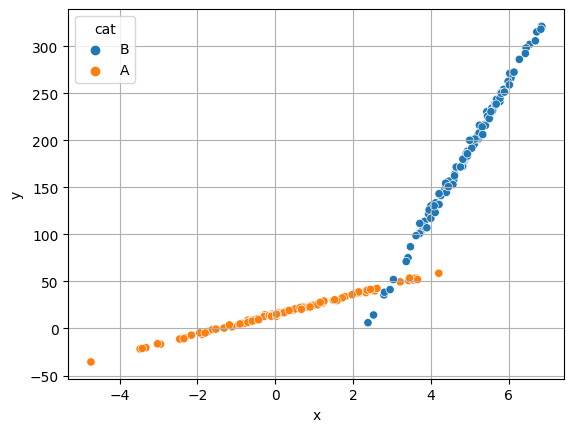

In [71]:
sns.scatterplot(x="x",y="y",data=df,hue='cat')
plt.grid();

## <font color=darkbrown>4.1 Fitting a Quadratic model</font>

In [72]:
X = df[["x", "cat"]]
y = df["y"]
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7, random_state = 30)

poly_features = PolynomialFeatures(include_bias=False, degree=2)
standard_scaler = StandardScaler()

preprocessor_x = Pipeline([("poly", poly_features),
                         ("scaler", standard_scaler)])

preprocessor_all_vars = ColumnTransformer(transformers = [("poly_and_scale_x", 
                                                           preprocessor_x,
                                                          ["x"])],
                                          remainder="drop")
final_pipeline = Pipeline([
    ("preprocessor",preprocessor_all_vars), 
    ("model",LinearRegression())
])


In [73]:
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('poly_and_scale_x',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['x'])])),
                ('model', LinearRegression())])

In [74]:
ypred = final_pipeline.predict(X_test)

In [75]:
print("Mean squared error on test set = {}".format(mean_squared_error(y_test, ypred)))

Mean squared error on test set = 340.30285634967237


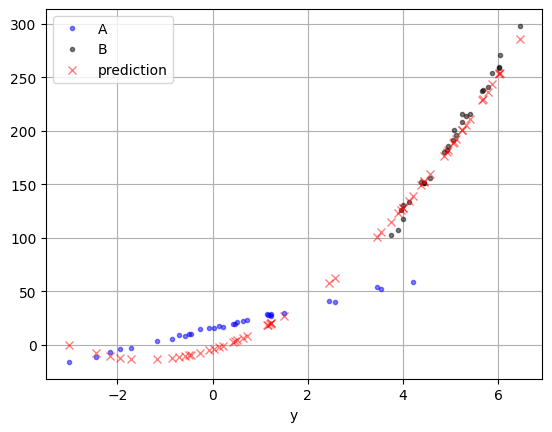

In [78]:
fig,ax = plt.subplots()
ax.plot(X_test.loc[X_test["cat"]=="A","x"], y_test.loc[X_test["cat"]=="A"], linestyle="None", marker=".", color="blue",alpha=0.5)
ax.plot(X_test.loc[X_test["cat"]=="B","x"], y_test.loc[X_test["cat"]=="B"], linestyle="None", marker=".", color="black",alpha=0.5)
ax.plot(X_test["x"], ypred, linestyle="None", marker="x", color="red",alpha=0.5)
ax.set_xlabel("x")
ax.set_xlabel("y")
ax.legend(["A","B","prediction"])
plt.grid();

But we know that the data does not really follow a quadratic model. How do we make use of the categorical variable here? Obviously we can build a linear regression model for every group, but that is extremely tedious for more complicated datasets and we do not know a priori what the model is, as for more complicated cases several different combinations have to be tried out. 

This is where the one-hot-encoder in combination with polynomial feature with `interactionly = True` comes in very useful. The steps are as follows. We one-hot-encode the categorical variable, then we multiply numerical variable with the one-hot-encoded columns to give the relevant features. The one-hot-encoded columns give the intercepts for the respective linear models and the interaction terms give the slopes.

And if the above steps are integrated it into a pipeline, the process of model building and training becomes much more simplified and several combinations of variables can be tried out.

However, it will be better to start off with a small dataset to get used to the preprocessing process.

In [94]:
dftest = pd.DataFrame(np.arange(1,10), columns=["x"])
dftest["cat"] = list(3*"A")+list(3*"B")+list(3*"C")
dftest

,x,cat
0,1,A
1,2,A
2,3,A
3,4,B
4,5,B
5,6,B
6,7,C
7,8,C
8,9,C


We want only interaction between x and cat. If we do the following we get an error. As we have seen earlier in the wrong way of doing things, the first transformer standardizes x, the next ohe hot encodes cat, and the third tries to encode the *original* x and cat, not the ones preprocessed by the previous transformers. tries to polynomize cat, a character, which results in an error.

In [59]:
vars_to_normalize = ["x"]
vars_to_ohe = ["cat"]
vars_interact = ["x", "cat"]

standard_scaler = StandardScaler() 
ohe = OneHotEncoder()
poly_features = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

x_transformer   = Pipeline(steps = [ ("scaler", standard_scaler) ])
cat_transformer = Pipeline(steps = [ ("one_hot_encoder", ohe)    ])
poly_transformer = Pipeline(steps = [ ("poly", poly_features)    ])

columns_transformer = ColumnTransformer(transformers = [   ("x_scaler", x_transformer, vars_to_normalize),
                                                           ("cat_ohe", cat_transformer, vars_to_ohe),
                                                           ("interact", poly_transformer, vars_interact)],
                                                           remainder="drop")
# SIMPLY PUTTING A 3RD TUPLE WITH POLYNOMIALFEATURE IN THE transformers LIST ABOVE AND DEFINING
# vars_poly = ["x", "cat"] RETURNS AN ERROR AS IT CONSIDERS THE ORIGINAL cat VARIABLE, WHICH IT CANNOT 
# MULTIPLY WITH NUMBERS.

In [60]:
pd.DataFrame(columns_transformer.fit_transform(dftest))

ValueError: could not convert string to float: 'A'

I will now describe a more promising approach which, hoever, is not without its problems either (see [here](https://github.com/scikit-learn/scikit-learn/issues/15263)). This approach consists of including the StandardScaler() and the OneHotEncoder() into a ColumnTransformer(). Then we wrap the ColumnTransformer() into a pipeline. This latter pipeline can, if wished, be wrapped into yet one more ColumnTransformer() for greater control over the variables.



In [80]:
dftest = pd.DataFrame(np.arange(1,10), columns=["x"])
dftest["cat"] = list(3*"A")+list(3*"B")+list(3*"C")
dftest

,x,cat
0,1,A
1,2,A
2,3,A
3,4,B
4,5,B
5,6,B
6,7,C
7,8,C
8,9,C


In [81]:
vars_to_normalize = ["x"]
vars_to_ohe = ["cat"]
vars_for_poly = ["x", "cat"]

standard_scaler = StandardScaler() 
ohe = OneHotEncoder()
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

x_transformer   = Pipeline(steps = [ ("scaler", standard_scaler) ])
cat_transformer = Pipeline(steps = [ ("one_hot_encoder", ohe)    ])
#poly_transformer= Pipeline(steps = [ ("poly_encoder", poly)    ])

columns_transformer = ColumnTransformer(transformers = [   ("x_scaler", x_transformer, vars_to_normalize),
                                                           ("cat_ohe", cat_transformer, vars_to_ohe)],
                                                           remainder="drop")

pipeline_1 = Pipeline(steps = [("coltrans1", columns_transformer),
                  ("poly", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))  ])

# the order of the interactions is
# AA AB AC AD BB BC BD CC CD DD for A, B, C, D.
pd.DataFrame(pipeline_1.fit_transform(dftest))

,0,1,2,3,4,5,6,7,8,9
0,-1.549193,1.0,0.0,0.0,-1.549193,-0.000000,-0.000000,0.0,0.0,0.0
1,-1.161895,1.0,0.0,0.0,-1.161895,-0.000000,-0.000000,0.0,0.0,0.0
2,-0.774597,1.0,0.0,0.0,-0.774597,-0.000000,-0.000000,0.0,0.0,0.0
3,-0.387298,0.0,1.0,0.0,-0.000000,-0.387298,-0.000000,0.0,0.0,0.0
4,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
5,0.387298,0.0,1.0,0.0,0.000000,0.387298,0.000000,0.0,0.0,0.0
6,0.774597,0.0,0.0,1.0,0.000000,0.000000,0.774597,0.0,0.0,0.0
7,1.161895,0.0,0.0,1.0,0.000000,0.000000,1.161895,0.0,0.0,0.0
8,1.549193,0.0,0.0,1.0,0.000000,0.000000,1.549193,0.0,0.0,0.0


As mentioned, you can further wrap the pipeline into a columntransformer so you can have more control over the variables to drop or passthrough.But the results are the same.

In [82]:
# wrapping pipeline_1 into a ColumnTransformer:
column_trans_poly = ColumnTransformer(transformers = [("scale_ohe_poly", pipeline_1, vars_for_poly)],
                                     remainder="drop")
pd.DataFrame(column_trans_poly.fit_transform(dftest))

,0,1,2,3,4,5,6,7,8,9
0,-1.549193,1.0,0.0,0.0,-1.549193,-0.000000,-0.000000,0.0,0.0,0.0
1,-1.161895,1.0,0.0,0.0,-1.161895,-0.000000,-0.000000,0.0,0.0,0.0
2,-0.774597,1.0,0.0,0.0,-0.774597,-0.000000,-0.000000,0.0,0.0,0.0
3,-0.387298,0.0,1.0,0.0,-0.000000,-0.387298,-0.000000,0.0,0.0,0.0
4,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
5,0.387298,0.0,1.0,0.0,0.000000,0.387298,0.000000,0.0,0.0,0.0
6,0.774597,0.0,0.0,1.0,0.000000,0.000000,0.774597,0.0,0.0,0.0
7,1.161895,0.0,0.0,1.0,0.000000,0.000000,1.161895,0.0,0.0,0.0
8,1.549193,0.0,0.0,1.0,0.000000,0.000000,1.549193,0.0,0.0,0.0


Explanation:

* First, `columns_transformer` scales x, then OHEs `cat` (the first 4 columns in the outpit), in the first step of `pipeline1`, then the second step of `pipeline1` finds the interactions between ALL the above 4 columns, resulting in the next 6 columns in the output above.

However, for a mixed linear regression model, the first column and the last three columns above are not useful. The first column will distort the interpretability of the model, while the last three are all zeros. So it would be better if we could remove columns 0, 7, 8 and 9. Of course we can do that manually, but we want a method to do that in the pipeline itself. 

However, at present, there is no built-in feature in sklearn at present to drop specific columns after the preprocessing (see [here](https://github.com/scikit-learn/scikit-learn/issues/15263)). Fortunately, there is a remedy. We can define our own preprocessor-class by inheriting from the BaseEstimator and TransformerMixin classes as follows.

In [83]:
class ColumnSelectorByIndex(BaseEstimator, TransformerMixin):
    """Custom transformer to select specific columns by index."""
    def __init__(self, indices):
        self.indices = indices

    def fit(self, X, y=None):
        return self  # No fitting needed

    def transform(self, X):
        """Select columns by index."""
        return X[:, self.indices] if isinstance(X, np.ndarray) else X.iloc[:, self.indices]
    
    
class ColumnDropper(BaseEstimator, TransformerMixin):
    """Custom transformer to drop specific columns by index."""
    def __init__(self, drop_indices):
        self.drop_indices = drop_indices  # Indices of columns to remove

    def fit(self, X, y=None):
        return self  # No fitting needed

    def transform(self, X):
        """Remove specified columns after transformation."""
        if isinstance(X, np.ndarray):
            return np.delete(X, self.drop_indices, axis=1)  # Remove columns by index
        else:
            return X.drop(X.columns[self.drop_indices], axis=1)  # For Pandas DataFrame

In [84]:
pipeline_1 = Pipeline(steps = [("coltrans1", columns_transformer),
                               ("polyfeatures", poly),
                               ("column_dropper", ColumnDropper([0,7,8,9]))])


column_trans_poly = ColumnTransformer(transformers = [("scale_ohe_poly", pipeline_1, vars_for_poly)],
                                     remainder="drop")

In [85]:
pd.DataFrame(column_trans_poly.fit_transform(dftest))

,0,1,2,3,4,5
0,1.0,0.0,0.0,-1.549193,-0.000000,-0.000000
1,1.0,0.0,0.0,-1.161895,-0.000000,-0.000000
2,1.0,0.0,0.0,-0.774597,-0.000000,-0.000000
3,0.0,1.0,0.0,-0.000000,-0.387298,-0.000000
4,0.0,1.0,0.0,0.000000,0.000000,0.000000
5,0.0,1.0,0.0,0.000000,0.387298,0.000000
6,0.0,0.0,1.0,0.000000,0.000000,0.774597
7,0.0,0.0,1.0,0.000000,0.000000,1.161895
8,0.0,0.0,1.0,0.000000,0.000000,1.549193


In the above we have removed columns 0, 7, 8 and 9.

Let us go back to our original problem. The OHE creates two columns. Hence after standardizing x and one-hot-encoding cat, we'll have 3 columns. Thereafter the PolynomialFeatures() object will create interactions in pairs, generating 3 more columns, leaving us with 6 columns in total. The first columns is the standardized value of x, and the last column is all zeros, being the interaction between two one-hot-encoded columns, and thus mutually and exclusively consisting of 0 or 1. Hence columns 0 and 5 should be removed after creating the interaction terms. 

In [87]:
df = dfbackup.copy()
df

,x,y,cat
60,5.067321,200.989069,B
10,4.000601,130.438900,B
87,0.473006,19.224873,A
40,1.222791,28.312502,A
51,2.794967,35.744730,B
...,...,...,...
63,6.830669,318.273754,B
72,5.547164,230.590215,B
1,0.674094,20.446849,A
76,2.451090,41.577234,A


In [88]:
vars_to_normalize = ["x"]
vars_to_ohe = ["cat"]
vars_for_poly = ["x", "cat"]

standard_scaler = StandardScaler() 
ohe = OneHotEncoder()
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

x_transformer   = Pipeline(steps = [ ("scaler", standard_scaler) ])
cat_transformer = Pipeline(steps = [ ("one_hot_encoder", ohe)    ])
#poly_transformer= Pipeline(steps = [ ("poly_encoder", poly)    ])

coltrans_scale_ohe = ColumnTransformer(transformers = [   ("x_scaler", x_transformer, vars_to_normalize),
                                                           ("cat_ohe", cat_transformer, vars_to_ohe)],
                                                           remainder="drop")




pipeline_1 = Pipeline(steps = [("coltrans1", coltrans_scale_ohe),
                               ("polyfeatures", poly),
                               ("column_dropper", ColumnDropper([0,5]))])


# the following may give us more control in case there are many variables you may want to drop:
column_trans_poly = ColumnTransformer(transformers = [("scale_ohe_poly", pipeline_1, vars_for_poly)],
                                     remainder="drop")
# but the result is the same as the previous case when there is nothing to drop.

pd.DataFrame(column_trans_poly.fit_transform(df))

,0,1,2,3
0,0.0,1.0,0.000000,0.902772
1,0.0,1.0,0.000000,0.512335
2,1.0,0.0,-0.778822,-0.000000
3,1.0,0.0,-0.504389,-0.000000
4,0.0,1.0,0.000000,0.071053
...,...,...,...,...
195,0.0,1.0,0.000000,1.548186
196,0.0,1.0,0.000000,1.078402
197,1.0,0.0,-0.705221,-0.000000
198,1.0,0.0,-0.054811,-0.000000


The relevant columns ahve been dropped above. Now we do the regression part as well in the next code block. For completeness I show the complete pipeline below.

In [89]:
df = dfbackup.copy()

vars_to_normalize = ["x"]
vars_to_ohe = ["cat"]
vars_for_poly = ["x", "cat"]

standard_scaler = StandardScaler() 
ohe = OneHotEncoder()
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

x_transformer   = Pipeline(steps = [ ("scaler", standard_scaler) ])
cat_transformer = Pipeline(steps = [ ("one_hot_encoder", ohe)    ])
#poly_transformer= Pipeline(steps = [ ("poly_encoder", poly)    ])

coltrans_scale_ohe = ColumnTransformer(transformers = [   ("x_scaler", x_transformer, vars_to_normalize),
                                                           ("cat_ohe", cat_transformer, vars_to_ohe)],
                                                           remainder="drop")

pipeline_1 = Pipeline(steps = [("coltrans1", coltrans_scale_ohe),
                               ("polyfeatures", poly),
                               ("column_dropper", ColumnDropper([0,5]))])


# the following may give us more control in case there are many variables you may want to drop:
column_trans_poly = ColumnTransformer(transformers = [("scale_ohe_poly", pipeline_1, vars_for_poly)],
                                     remainder="drop")
# but the result is the same as the previous case when there is nothing to drop.

pipeline2 = Pipeline(steps=[("p1", pipeline_1),
                            ("regr", LinearRegression())])

#pd.DataFrame(column_trans_poly.fit_transform(df))

In [90]:
X = df[["x", "cat"]]
y = df["y"]
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7, random_state = 30)

In [91]:
pipeline2.fit(X_train, y_train)

Pipeline(steps=[('p1',
                 Pipeline(steps=[('coltrans1',
                                  ColumnTransformer(transformers=[('x_scaler',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler())]),
                                                                   ['x']),
                                                                  ('cat_ohe',
                                                                   Pipeline(steps=[('one_hot_encoder',
                                                                                    OneHotEncoder())]),
                                                                   ['cat'])])),
                                 ('polyfeatures',
                                  PolynomialFeatures(include_bias=False,
                                                     interaction_only=True)),
                                 ('column_dropper',
                                  ColumnDropper(drop_indices=[0, 5]))])),
                ('regr', LinearRegression())])

In [92]:
ypred = pipeline2.predict(X_test)
print("Mean squared error on test set = {}".format(mean_squared_error(y_test, ypred)))

Mean squared error on test set = 9.54160018555755


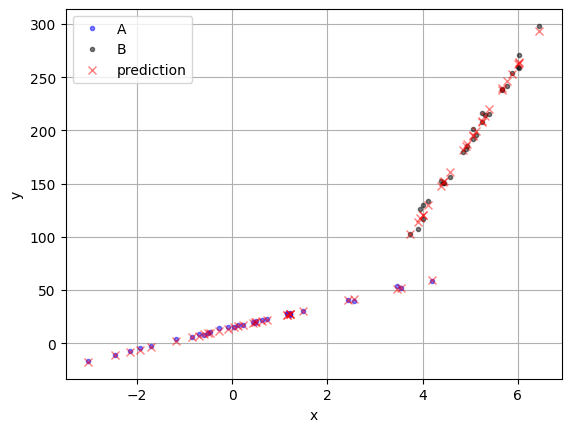

In [94]:
fig,ax = plt.subplots()
ax.plot(X_test.loc[X_test["cat"]=="A","x"], y_test.loc[X_test["cat"]=="A"], linestyle="None", marker=".", color="blue",alpha=0.5)
ax.plot(X_test.loc[X_test["cat"]=="B","x"], y_test.loc[X_test["cat"]=="B"], linestyle="None", marker=".", color="black",alpha=0.5)
ax.plot(X_test["x"], ypred, linestyle="None", marker="x", color="red",alpha=0.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(["A","B","prediction"])
plt.grid();

# <font color=darkbrown>5. Further Steps</font>

When there are many numerical variables and many categorical variables, the number of combinations can become huge. It may be difficult to try out all the combinations. Yet when there are not so many variables one could follow the general framework as given below. Let's say we have $N_n$ numerical variables ($x_1$, $x_2$, ...$x_{N_n}$) and $N_c$ categorical variables ($c_1$, $c_2$, $c_{N_c}$). Then we can try:

* Interactions of the form `xi*cj`. There are $N_n\times N_c$ such combinations.
* Interactions of the form `xi*(cj*ck)`. There are $N_n\times ^{N_c}C_2$ such combinations.
* Interactions of the form `xi*(cj*ck*cl)`. There are $N_n\times ^{N_c}C_3$ such combinations.
* Interactions of the form `xi*cj` and `xk*cl` with i not equal to k. (i=k is considered earlier). So two different numerical variables interacting with all possible categorical variables. There are $^{N_n}C_2\times N_c^2$ such combinations.
* Interactions of the form `xi*cj` and `xk*cl*clm`
* etc.
* etc.


Some idea for the best features to select can be provided by sklearn.feature_selection. The package `mlxtend` (https://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/) does something along these lines in an automated way.


# <font color=darkbrown>6. Final Thoughts</font>

If you have any feedback, or if there is something that I missed, or something that can be done better, please drop me a line. I will be happy to hear from you. My email is bhaskarkamble2019@gmail.com.

**Interesting Preprocessing Steps in sklearn**

In [128]:
pd.read_html("https://scikit-learn.org/stable/api/sklearn.preprocessing.html")[0]

,0,1
0,Binarizer,Binarize data (set feature values to 0 or 1) a...
1,FunctionTransformer,Constructs a transformer from an arbitrary cal...
2,KBinsDiscretizer,Bin continuous data into intervals.
3,KernelCenterer,Center an arbitrary kernel matrix \(K\).
4,LabelBinarizer,Binarize labels in a one-vs-all fashion.
5,LabelEncoder,Encode target labels with value between 0 and ...
6,MaxAbsScaler,Scale each feature by its maximum absolute value.
7,MinMaxScaler,Transform features by scaling each feature to ...
8,MultiLabelBinarizer,Transform between iterable of iterables and a ...
9,Normalizer,Normalize samples individually to unit norm.


https://www.kaggle.com/code/ojwatson/mixed-models